In [1]:
import numpy as np
from scipy import linalg
from scipy import special
from scipy import sparse
from matplotlib import pyplot as plt

from copy import deepcopy

from functools import reduce

In [2]:
import unittest
import sys

##### **Procedure to compute** $U_1, \dots, U_l$

**Comment** \[Input to this procedure consists of the number of points $n$, the number of zero moments $k$, and the points $x_1, \dots, x_n$. Output is the matrices $U_{j,i}$ for $j = 1, \dots, l$ and $\displaystyle i = l, \dots, \frac{n}{2^jk}$, which make up the matrices $U_1, \dots, U_l$ (note $\displaystyle l = \log_2 \left( \frac{n}{k} \right)$).\]

<h5 style="text-align: center; font-weight: bold;"> Step 1. </h5>

Compute the shifted and scaled moments matrices $M'_{1,i}$ for $\displaystyle i = 1, \dots, \frac{n}{2k}$.

__Alexandre Comment:__

* In the text $j$ ranges from $1$ to $l$, in the code it'll range from $0$ to $l-1$.
* In the text $i$ ranges from $1$ to $\displaystyle \frac{n}{k 2^j}$, in the code it'll range from $0$ to $\displaystyle \frac{n}{k 2^j} - 1$.
* There's a compensation for the fact that - besides $i$ and $j$ starting in $0$ instead of $1$ - `xs` is indexed starting in $0$.

##### Formulae for step 1:

| Symbol   | Text definition &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; | Implementation &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;|
|:---------|:---------------------------------------------------|:---------------------------------------------------------------|
| $\mu$    | $\mu_{j,i} = x_{1 + (i-1) k 2^j} + x_{i k 2^j}$    | $\mu_{j,i} = x_{i k 2^{(j+1)}} + x_{(i+1) k 2^{(j+1)} - 1}$    |
| $\sigma$ | $\sigma_{j,i} = x_{i k 2^j} - x_{1 + (i-1) k 2^j}$ | $\sigma_{j,i} = x_{(i+1) k 2^{(j+1)} - 1} - x_{i k 2^{(j+1)}}$ |
| $s$      | $s_i = (i-1) 2k$                                   | $s_i = i 2 k$                                                  |

##### What about the `_builder()` functions?

__Short version:__ I'm trying to respect the D.R.Y. (Don't Repeat Yourself) principle when passing the arguments.

__Complementing the short version:__ it's easy to write higher order functions in Python and I wanted the function calls to look like the text as much as possible. But I wanted other two features to my code, besides being readable:
1. it should avoid side effects (it helps to look more mathematical)
2. neither "mathematicality" nor readability should be given up for the sake of the other

In [3]:
def mu_builder (xs, k):
    def mu (j, i):
        idx = ( i*k*2**(j+1), (i+1)*k*2**(j+1)-1 )
        return ( xs[ idx[0] ] + xs[ idx[1] ] ) / 2
    
    return mu

def sigma_builder (xs, k):
    def sigma (j, i):
        idx = ( (i+1)*k*2**(j+1)-1, i*k*2**(j+1) )
        return ( xs[ idx[0] ] - xs[ idx[1] ] ) / 2
    
    return sigma

def s_builder (k):
    def s (i):
        return i*2*k
    
    return s

In [4]:
def shifted_scaled_matrices (xs, k, l): # M'0,i
    n = len(xs)
    assert n % (2*k) == 0
    
    mu = mu_builder(xs, k)
    sigma = sigma_builder(xs, k)
    s = s_builder(k)
    
    Ms = []
    for i in range(n//(2*k)): # matrices loop
        s_i = s(i)
        mu_0_i = mu(0,i)
        sigma_0_i = sigma(0,i)
        
        M = np.ones((2*k,2*k))
        for r in range(2*k): # rows loop
            for c in range(1,2*k): # entries loop
                M[r,c] = ( (xs[s_i + r] - mu_0_i) / sigma_0_i )**c
        
        Ms.append( deepcopy(M) )
    
    return Ms

<h5 style="text-align: center; font-weight: bold;">Step 2.</h5>

Compute $U_{1,i}$ from $M'_{1,i}$ by Eq. (4.11) using Gram-Schmidt (?) orthogonalization for $i = 1,\dots, \frac{n}{2k}$.

In [5]:
def U_j_i (M_j_i):
    return linalg.qr(M_j_i)[0].T

<h5 style="text-align: center; font-weight: bold;">Step 3.</h5>

**Comment** \[Compute $M'_{j,i}$ and $U_{j,i}$ for $j = 2, \dots, l$ and $\displaystyle i = 1, \dots, \frac{n}{2^jk}$\.]

<!-- Seja M uma matriz m x n, M^U é a matriz m/2 x n formada pelas m/2 primeiras linhas de M -->
<!-- Seja M uma matriz m x n, M^L é a matriz m/2 x n formada pelas m/2 últimas linhas de M -->

<img src="step-3_algorithm.jpg">

<!--
```
do j = 2, ..., l
    do i = 1, ..., n/(2^j*k)
        Compute U_j-1,2i-1^U M'_j-1,2i-1 and U_j-1,2i^U M'_j-1,2i.
        Compute S^1_j,i by Eq. (4.16) and S^2_j,i by Eq. (4.17);
            multiply to obtain M'_j,i by Eq. (4.13).
        Orthogonalize M'_j,i to obtain U_j,i by Eq. (4.11).
    enddo
enddo
```
-->

In [6]:
def upper_half_rows (matrix):
    rows = matrix.shape[0] # checks if there's an even number of rows
    assert rows % 2 == 0
    
    return matrix[:rows//2, :]

def lower_half_rows (matrix):
    rows = matrix.shape[0] # checks if there's an even number of rows
    assert rows % 2 == 0
    
    return matrix[rows//2:, :]

__Alexandre Comment:__

It's necessary to make some compensations to the indices for defining $S^1_{j,i}$ and $S^2_{j,i}$. I've observed that: 
1. the $j$ index starts at the second possible position; and 
2. the $i$ index iterate through all possible indices.

The way I've written the functions for $\mu$ and $\sigma$ require some adaptions to make the $i$ index start where it should, even though I'm starting at $0$ instead of $1$. My solutions for this problem are resumed in the table below.

##### Formulae for $S^1$ and $S^2$:

| Symbol   | Text definition &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;| Implementation &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;|
|:---------|:---------------------------------------------------|:---------------------------------------------------------------|
| $S^1$ | $\displaystyle S^1_{j,i} = S \biggl( \biggl( \frac{\mu_{j,i} - \mu_{j-1,2i-1}}{\sigma_{j-1,2i-1}} \biggr), \frac{\sigma_{j,i}}{\sigma_{j-1,2i-1}} \biggr)$ | $\displaystyle S^1_{j,i} = S \biggl( \biggl( \frac{\mu_{j,i} - \mu_{j-1,2i}}{\sigma_{j-1,2i}} \biggr), \frac{\sigma_{j,i}}{\sigma_{j-1,2i}} \biggr)$ |
| $S^2$ | $\displaystyle S^2_{j,i} = S \biggl( \biggl( \frac{\mu_{j,i} - \mu_{j-1,2i}}{\sigma_{j-1,2i}} \biggr), \frac{\sigma_{j,i}}{\sigma_{j-1,2i}} \biggr)$ | $\displaystyle S^2_{j,i} = S \biggl( \biggl( \frac{\mu_{j,i} - \mu_{j-1,2i+1}}{\sigma_{j-1,2i+1}} \biggr), \frac{\sigma_{j,i}}{\sigma_{j-1,2i+1}} \biggr)$ |

In [7]:
def shift_scale_matrix_entry (mu_value, sigma_value, i, j): # S(μ,σ)i,j
    return special.binom(j, i)*(-mu_value)**(j-i)/sigma_value**j

def shift_scale_matrix_builder (xs, k):
    def shift_scale_matrix (mu_value, sigma_value): # S(μ,σ)
        return np.array([
            [ shift_scale_matrix_entry(mu_value, sigma_value, i, j) for j in range(2*k) ] for i in range(2*k)
        ])
    
    return shift_scale_matrix

def shift_scale_upper_builder (xs, k, mu=None, sigma=None):
    '''Builder function shift-scale matrix (S¹) for the upper half of the M' matrix'''
    if mu is None:
        mu = mu_builder(xs, k)
    
    if sigma is None:
        sigma = sigma_builder(xs, k)
    
    S = shift_scale_matrix_builder(xs, k)
    
    def shift_scale_upper (j, i):
        '''Shift-scale (S¹) matrix for the upper half of the M' matrix'''
        # this indices (j, i) are not the entries of the matrix
        # instead those denote a matrix in a bidimensional collection of matrices
        m = (mu(j, i) - mu(j-1, 2*i)) / sigma(j-1, 2*i)
        s = sigma(j, i) / sigma(j-1, 2*i)
        
        return S(m, s)
    
    return shift_scale_upper

def shift_scale_lower_builder (xs, k, mu=None, sigma=None):
    '''Builder function shift-scale matrix (S²) for the lower half of the M' matrix'''
    if mu is None:
        mu = mu_builder(xs, k)
    
    if sigma is None:
        sigma = sigma_builder(xs, k)
    
    S = shift_scale_matrix_builder(xs, k)
    
    def shift_scale_lower (j, i):
        '''Shift-scale matrix (S²) for the lower half of the M' matrix'''
        # this indices (j, i) are not the entries of the matrix
        # instead those denote a matrix in a bidimensional collection of matrices
        m = (mu(j, i) - mu(j-1, 2*i+1)) / sigma(j-1, 2*i+1)
        s = sigma(j, i) / sigma(j-1, 2*i+1)
        
        return S(m, s)
    
    return shift_scale_lower

In [8]:
def n_j_builder (n, k):
    def n_j (j):
        return n // (2**(j+1)*k)
    
    return n_j

In [9]:
def orth_moments_matrices_builder (xs, k): # all Uj,i
    n = len(xs)
    assert n % (2*k) == 0
    
    l = int( np.log2(n/k) )
    
    mu = mu_builder(xs, k)
    sigma = sigma_builder(xs, k)
    
    S_1 = shift_scale_upper_builder(xs, k, mu=mu, sigma=sigma)
    S_2 = shift_scale_lower_builder(xs, k, mu=mu, sigma=sigma)
    
    n_j = n_j_builder(n, k)
    
    def orth_moments_matrices (M_1s):
        Ms_prev = deepcopy(M_1s)
        Us = [ [ U_j_i(M) for M in Ms_prev ] ]
        for j in range(1,l):
            Ms_current = []
            Us.append([])
            
            nj = n_j(j)
            for i in range(nj):
                
                M_upper_half = upper_half_rows( Us[j-1][2*i] ) @ Ms_prev[2*i] @ S_1(j,i)
                M_lower_half = upper_half_rows( Us[j-1][2*i+1] ) @ Ms_prev[2*i+1] @ S_2(j,i)
                
                rows, columns = M_upper_half.shape
                M_j_i = np.empty((2*rows, columns))
                M_j_i[:rows] = M_upper_half
                M_j_i[rows:] = M_lower_half
                
                Ms_current.append(deepcopy(M_j_i))
            
            Us[j] += [ U_j_i(M) for M in Ms_current ]
        
        return Us
    
    return orth_moments_matrices

In [10]:
def basis_matrices_builder (n, k, l): # U_j
    n_ = n_j_builder(n, k)
    
    def basis_matrix (U_j_is, j):
        U = U_j_is
        nj = n_(j)
        U_prime_j = np.zeros( (2*k*nj, 2*k*nj) )
        
        for i in range(nj):
            row, row_next = i*k, (i + 1)*k
            col, col_next = 2*row, 2*row_next
            
            U_prime_j[row:row_next, col:col_next] = lower_half_rows(U[j][i])
            
            row, row_next = 2*i*k, (2*i + 1)*k
            
            U_prime_j[row:row_next, col:col_next] = upper_half_rows(U[j][i])
        
        if j == 0:
            Uj = U_prime_j
        else:
            Uj = np.zeros((n,n))
            Uj[:n-n//2**j, :n-n//2**j] = np.eye(n-n//2**j)
            Uj[n-n//2**j:, n-n//2**j:] = U_prime_j
        
        return sparse.lil_matrix(Uj)
    
    def basis_matrices (U_j_is):
        return [ basis_matrix(U_j_is, j) for j in range(l) ]
    
    return basis_matrices

In [11]:
# class BasisMatricesTestClass (unittest.TestCase):
#     def setUp (self):
#         n, k, self.l = 32, 4, 3
#         xs = np.linspace(0, 1, n)
        
#         M_1s = shifted_scaled_matrices(xs, k, self.l)
        
#         U_i_js_ = orth_moments_matrices_builder(xs, k)
#         U_i_js = U_i_js_(M_1s)
        
#         Us_ = basis_matrices_builder(n, k, self.l)
#         self.Us = Us_(U_j_is)
    
#     def plot (self):
#         for j in range(self.l):
#             plt.spy(self.Us[j])

In [12]:
# suite = unittest.TestLoader().loadTestsFromTestCase(BasisMatricesTestClass)
# unittest.TextTestRunner(verbosity=4, stream=sys.stderr).run(suite)

In [13]:
n, k, l = 32, 4, 3
xs = np.linspace(0, 1, n)

M_1s = shifted_scaled_matrices(xs, k, l)

U_j_is_ = orth_moments_matrices_builder(xs, k)
U_j_is = U_j_is_(M_1s)

Us_ = basis_matrices_builder(n, k, l)
Us = Us_(U_j_is)

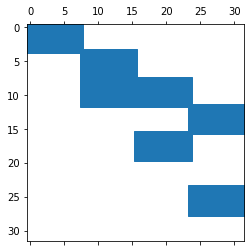

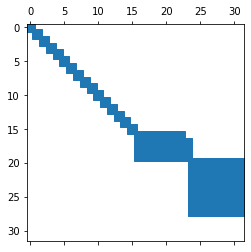

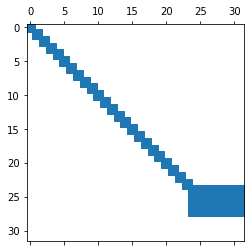

In [25]:
for j in range(l):
    plt.figure(j)
    plt.spy(Us[j])

##### **Procedure to compute** $UTU^T$

**Comment** [Input to this procedure consists of $n, k$, the matrices $U_{j,i}$ computed above, a function to compute elements of $T$, and the chosen precision $\varepsilon$. Output is a matrix $R_l$ such that $\lVert R_l - UTU^T \rVert \lt \varepsilon \lVert T \rVert $.]

<h5 style="text-align: center; font-weight: bold;">Step 4.</h5>

Compute the $k \times k$ extracts, indicated by Eq. (4.18), of the submatrices of $T$ shown in Fig. 4.4.

<img src="fig_4.4.jpg" style="width: 70%;">

In [15]:
# calculate matrix T, K is a kernel function with 2 arguments
def trapezoidal_matrix (xs, K):
    n = len(xs)
    
    return np.array(
        [
            [ 0 if i == j else K(x_i, x_j)/(n-1) for j,x_j in enumerate(xs) ] 
            for i,x_i in enumerate(xs) 
        ]
    )

In [16]:
def extract_symmetric_block_diag (M, index, block_size):
    assert isinstance(M, np.ndarray)
  
    rows, columns = M.shape
    assert rows == columns

    size = rows
    assert size >= index+block_size

    N = deepcopy(M)
    R = np.zeros_like(N)

    for j in range(index, size, block_size):
        i = j-index
        R[i:i+block_size, j:j+block_size] = N[i:i+block_size, j:j+block_size]
        N[i:i+block_size, j:j+block_size] = np.zeros( (block_size, block_size) )

        if i != j:
            R[j:j+block_size, i:i+block_size] = N[j:j+block_size, i:i+block_size]
            N[j:j+block_size, i:i+block_size] = np.zeros( (block_size, block_size) )
  
    return N, R

__Alexandre:__ This "either" in the image below may be wrong, probably the only right option is suplying a column to start in. The `extract_symmetric_block_diag()` function receives a matrix and outputs two matrices: 

* the first one is the original with zeros in the places from where the submatrices were extracted; 
* the second is the the matrix of the extracted submatrices

<img src="sym-block-diag.jpg" style="text-align:center" />

In [17]:
def submatrices_T (T, k, l):
    n = T.shape[0]

    block_sizes = ( 2**i*k for i in range(l-2,0,-1) )

    Ts = []

    T_0 = deepcopy(T)
    T_i = np.zeros_like(T_0)
    start_index = n
    
    for block_size in block_sizes:
        start_index -= block_size
        T_0, T_i_0 = extract_symmetric_block_diag(T_0, start_index, block_size)

        start_index -= block_size
        T_0, T_i_1 = extract_symmetric_block_diag(T_0, start_index, block_size)

        T_i = T_i_0 + T_i_1
        Ts = [deepcopy(T_i)] + Ts

    return [T_0] + Ts

In [18]:
def extract_from_T_matrices (Ts, k):
    n = Ts[0].shape[0]
    
    start = n // k #- 1
    return [ T[start::k, start::k] for T in Ts ]

<h5 style="text-align: center; font-weight: bold;">Step 5.</h5>

Extract the matrices $P''$ (Eq. (4.19)) from $U_1, U_2U_1, \dots, U_l \dots U_1$ and compute $W_0, \dots, W_{l-2}$ according to Eqs. (4.20).

In [19]:
# deu ruim, os Us começam índices no 1 e os Vs no 0. tenho que rever isso escrever as docstrings, testes e plots

def dot_product (X, Y):
    return X @ Y

def P_prime_matrices (U_js, n, k):
    I = sparse.eye(n)
    
    return [ reduce(dot_product, U_js[j:-1:-1], I).tolil()[-k:] for j,_ in enumerate(U_js) ]

def P_second_matrices (P_primes, n, k):
    return [ P_prime[:,::n//k] for P_prime in P_primes ]        

In [20]:
# def W_matrices (P_seconds, Vs):
#     return [  for i,(P_second,V) in enumerate(zip(P_seconds, Vs)) ]

<h5 style="text-align: center; font-weight: bold;">Step 6.</h5>

Compute $R_0, \dots, R_l$ by Eq. (4.21), discarding elements below a threshold $\tau$ determined by the precision $\varepsilon$ (Eq. (4.22))

##### **Procedure to compute** $UT^{-1}U^T$

**Comment** \[Input to this procedure consists of n the matrix $R_l$ which approximates $UTU^T$, and the precision $\varepsilon$. Output is a matrix $X_m$ that approximates $UT^{-1}U^T$.\]

<h5 style="text-align: center; font-weight: bold;">Step 7.</h5>

Compute the matrix $\displaystyle X_0 = \frac{R_l T R_l}{\lVert R_l T R_l \rVert}$ by direct matrix multiplication, discarding elements below a threshold $\tau$ determined by the precision $\varepsilon$ (Eq. (4.22))

<h5 style="text-align: center; font-weight: bold;">Step 8.</h5>

**Comment** \[Obtain the inverse by Schulz iteration.\]

```
do m = 0, 1, ... while ||I - X_m R_l|| > epsilon
    Compute X_m+1 = 2 X_m - X_m R_l X_m, discarding elements below threshold
enddo
```